In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-insincere-questions-dataset/train.csv


In [2]:
import string
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding, Bidirectional, LSTM, Dropout, Flatten, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras import  regularizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import nltk 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')

2024-08-21 07:20:10.774075: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 07:20:10.774137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 07:20:10.776042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import subprocess         # Having some issue while import wordnet in kaggle enviornment this code resolve the issue

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


# EDA

In [4]:
df = pd.read_csv('/kaggle/input/quora-insincere-questions-dataset/train.csv')
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [6]:
df.drop('qid', inplace=True, axis=1)

In [7]:
print(df.target.value_counts())
print(df.target.value_counts(normalize=True))

target
0    1225312
1      80810
Name: count, dtype: int64
target
0    0.93813
1    0.06187
Name: proportion, dtype: float64


<Axes: xlabel='target'>

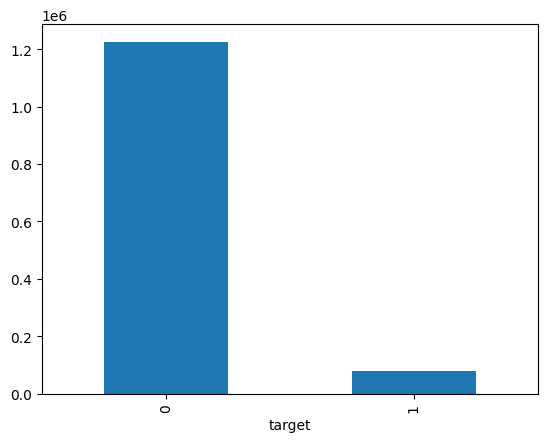

In [8]:
df.target.value_counts().plot(kind='bar')

In [9]:
df.question_text.head().values

array(['How did Quebec nationalists see their province as a nation in the 1960s?',
       'Do you have an adopted dog, how would you encourage people to adopt and not shop?',
       'Why does velocity affect time? Does velocity affect space geometry?',
       'How did Otto von Guericke used the Magdeburg hemispheres?',
       'Can I convert montra helicon D to a mountain bike by just changing the tyres?'],
      dtype=object)

In [10]:
df.query('target == 1')['question_text'].sample(5).values

array(['How do I teach an ENTP when to shut their mouth?',
       'Should popular Quorans be banned for the upvotes they get just because of their popularity?',
       'Which state in India are the most rude and rough in their behaviour?',
       "What would happen if the entire nation of Russia was completely obliterated, with everyone within its borders dead? I'm only looking for political and social effects unrelated to what caused it.",
       'Why do many Sikhs think low about Hindu Brahmins and badly call them pandat or pandu and even not think good about Shudras and call them Mazhabi? Do they like Kshtriyas and Vaishyas only?'],
      dtype=object)

In [11]:
sincere_df = df[df.target == 0]
insincere_df = df[df.target == 1] 

In [12]:
print(sincere_df.info())
print(insincere_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1225312 entries, 0 to 1306121
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   question_text  1225312 non-null  object
 1   target         1225312 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 28.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 80810 entries, 22 to 1306112
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   question_text  80810 non-null  object
 1   target         80810 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB
None


# Feature Engineering

In [13]:
train_df = sincere_df.sample(int(len(insincere_df) * 1.5 ))  

train_df = pd.concat([train_df,insincere_df], ignore_index=True)

train_df = train_df.sample(len(train_df))

train_df.reset_index(drop = True, inplace=True)       # Downsampling

In [14]:
train_df.sample(10)

,question_text,target
145588,"Recently, the theory came up in European news ...",1
38302,Can I pursue medical research through JEE?,0
43021,"If I ship a guitar and case via UPS, do I have...",0
148262,Why are native English speakers usually not ve...,1
62286,Will conservatives be as forgiving the day we ...,1
52150,Why are you calling Yashaya Jewish he is a Heb...,1
79402,What are the pros and cons of getting an ITIN ...,0
102661,How is solar system in realitty?,0
112663,Can a person practice both law and CS at the s...,0
40603,Why are (not all but most and specially Indian...,1


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202025 entries, 0 to 202024
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   question_text  202025 non-null  object
 1   target         202025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [16]:
def exclude_punc(text):
    rp = string.punctuation
    return text.translate(str.maketrans('','', rp))

In [17]:
train_df['question_text'] = train_df['question_text'].map(exclude_punc) # excluding punctutions

In [18]:
train_df.question_text = train_df.question_text.apply(lambda x: x.lower()) #lower casing

In [19]:
train_df.question_text.sample(10).values

array(['what is the hatchet series called',
       'why do chinese tourists keep being blinded by the chinese tour guide that vietnam belongs to their country dont they have google to search',
       'how do i ask mt sister to see her naked',
       'when are federal taxes withheld from smaller amount income',
       'what do ukranians think of portugal and do they know they are the most numerous european community there',
       'how do i tell my friends to stop playing with my son’s penis',
       'what should be the goal of humanity',
       'what should i definitely do at burbank california when visiting during vacations',
       'if you rolled two dice 1000 times how many times would you get a sum of two',
       'what are the characteristics of the maasai garment called the shuka'],
      dtype=object)

In [20]:
stop_words = set(stopwords.words('english'))                 # tokenizing and removing stopwords

def remove_stop(text):
    # Split the text into words
    words = word_tokenize(text)
    
    # Filter out stop words
    filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
    
    # Join the filtered words back into a single string
    return filtered_words


train_df.question_text = train_df.question_text.apply(remove_stop)

In [21]:
train_df.question_text.sample(5).values

array([list(['certifications', 'companies', 'look', 'recruiting', 'entry', 'level', 'business', 'analyst']),
       list(['website', 'staylaid', 'fake']),
       list(['cutoff', 'mark', 'deducted', 'total', 'marks', 'obtained', 'icse', 'want', 'get', 'admission', 'wbbhsecbsc', 'standard', 'migration', 'board']),
       list(['see', 'tomahawks', 'falling', 'turkey', 'like', 'trump', 'syria']),
       list(['polyglottery', 'helped', 'professional', 'career'])],
      dtype=object)

In [23]:
#nltk.download('wordnet')                                # lemmatizing words into their base form
lemme = WordNetLemmatizer()

def lemmatization(text):

    lemmatized_text = [lemme.lemmatize(word) for word in text]
    return lemmatized_text

train_df.question_text = train_df.question_text.apply(lemmatization)

In [24]:
train_df.question_text.sample(10).values

array([list(['start', 'learning', 'mathematics', 'scratch', 'computer', 'engineering', 'student', 'university', 'mathematics', 'different', 'high', 'school', 'mathematics', 'always', 'find', 'get', 'asked', 'proof', 'something', 'exam', 'dont', 'know', 'study']),
       list(['people', 'calling', 'stupid', 'abandoned', 'uk', 'indian', 'go']),
       list(['christian', 'priest', 'rape', 'woman', 'india']),
       list(['india', 'ever', 'involved', 'witnessed', 'incest']),
       list(['disadvantage', 'separatiststates', 'rightsquora', 'user', 'restrict', 'voting', 'right', 'underfund', 'school', 'colored', 'american', 'cage', 'immigrant', 'asylum', 'seeker', 'obstruct', 'basic', 'right']),
       list(['democrat', 'chanting', 'lock', 'america', 'far', 'trump', 'ever', 'hilary', 'clinton', 'booing', 'hissing', 'apparently', 'crooked', 'family']),
       list(['happen', 'splash', 'full', 'load', 'kg', 'cum', 'face', 'as']),
       list(['main', 'thing', 'check', 'purchasing', 'air', 'cool

In [25]:
emb_dim = 300
w2v = Word2Vec(min_count=2, window=7, vector_size= emb_dim)

w2v.build_vocab(train_df.question_text)

In [26]:
w2v.train(train_df.question_text, total_examples=w2v.corpus_count, epochs=20)

(27697862, 29524280)

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['question_text'])

In [28]:
word_index = tokenizer.word_index
len(tokenizer.word_index)         # vocabulary

69818

In [29]:
sequences = tokenizer.texts_to_sequences(train_df['question_text'])
sequences[:10]

[[30, 649, 167, 649, 4305, 563],
 [21, 496, 20, 9, 17, 205, 486, 4374],
 [793, 1552, 1492],
 [3862, 3981, 156, 23832],
 [984, 3597, 888, 1987, 888, 368],
 [356, 172, 2794],
 [8, 1468, 1294, 604, 27, 5847, 17, 442],
 [376, 363, 409, 973, 3323],
 [12, 32008, 75, 43, 10757, 1077],
 [89,
  205,
  527,
  1119,
  74,
  515,
  48,
  1553,
  1469,
  605,
  4964,
  1023,
  297,
  333,
  148,
  656,
  3863,
  478,
  182]]

In [30]:
maxseq = max([len(seq) for seq in sequences])
maxseq 

33

In [31]:
sequences = pad_sequences(sequences, padding='post', maxlen = maxseq)
sequences[:5]     # padded sequences with max length of 33

array([[   30,   649,   167,   649,  4305,   563,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   21,   496,    20,     9,    17,   205,   486,  4374,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [  793,  1552,  1492,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [ 3862,  3981,   156, 23832,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,   

In [32]:
#key_vector = w2v.wv

emb_mat = np.zeros((len(word_index)+1, emb_dim))
for word, i in word_index.items():
    if word in w2v.wv:
        emb_mat[i] = w2v.wv[word]

In [33]:
missing_words = [word for word in word_index if word not in w2v.wv]
print(f"Number of missing words: {len(missing_words)}")
print(f"Sample missing words: {missing_words[:10]}") # words that are not present in W2V so the embedding matrix contains zero

Number of missing words: 37811
Sample missing words: ['southeners', 'goodnormal', 'fiddling', 'acuse', 'absentee', 'websiteplatform', 'pyra', 'blogpublishing', 'cryptotoken', 'stampede']


In [34]:
xtrain, xtest, ytrain,ytest = train_test_split(sequences, train_df.target, test_size=0.1,
                                               stratify=train_df.target)

In [35]:
xtrain.shape , xtest.shape

((181822, 33), (20203, 33))

In [36]:
ytrain.shape, ytest.shape

((181822,), (20203,))

# Modelling

In [37]:
model = Sequential()

model.add(Embedding(len(word_index) + 1, emb_dim, weights=[emb_mat], trainable=True))  # to further train our embedding

model.add(Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=regularizers.L2(2e-4))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=regularizers.L2(2e-4))))
model.add(Dropout(0.4))

model.add(Bidirectional(LSTM(50,return_sequences=False,
                             kernel_regularizer=regularizers.L2(2e-4))))
#model.add(Dropout(0.3))

#model.add(Flatten())
#model.add(GlobalMaxPooling1D())

model.add(Dense(64, activation ='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [38]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_delta=0.003, verbose=1)
es = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=4, verbose=1)

In [40]:
history = model.fit(xtrain, ytrain, epochs=20, validation_data=[xtest,ytest] ,
                    batch_size=128, callbacks=[reducelr,checkpoint, es])

Epoch 1/20
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8646 - loss: 0.4511
Epoch 1: val_accuracy improved from -inf to 0.88754, saving model to model.keras
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 64s 39ms/step - accuracy: 0.8646 - loss: 0.4511 - val_accuracy: 0.8875 - val_loss: 0.3070 - learning_rate: 0.0010
Epoch 2/20
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9045 - loss: 0.2687
Epoch 2: val_accuracy improved from 0.88754 to 0.88952, saving model to model.keras
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 56s 39ms/step - accuracy: 0.9045 - loss: 0.2687 - val_accuracy: 0.8895 - val_loss: 0.2983 - learning_rate: 0.0010
Epoch 3/20
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9223 - loss: 0.2234
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 3: val_accuracy did not improve from 0.88952
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 54s 38ms/step - accuracy: 0.9223 - loss: 0.2234 - val_accuracy: 0.8859 - val_loss: 0.3065 - learning_rate: 0.0010
Epoc

Text(0, 0.5, 'Accuracy')

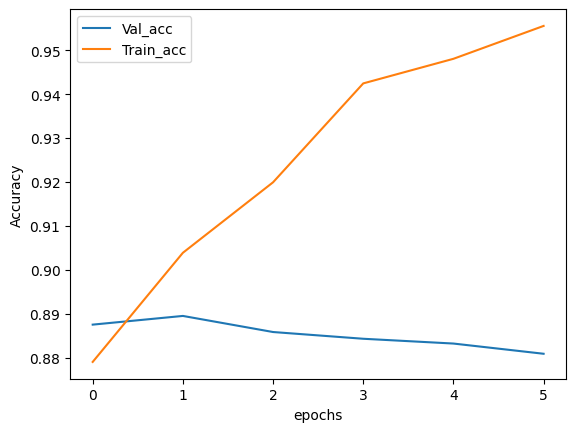

In [41]:
plt.plot(history.history['val_accuracy'], label='Val_acc')
plt.plot(history.history['accuracy'], label='Train_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Accuracy')

Text(0.5, 1.0, 'Training v Validation Loss')

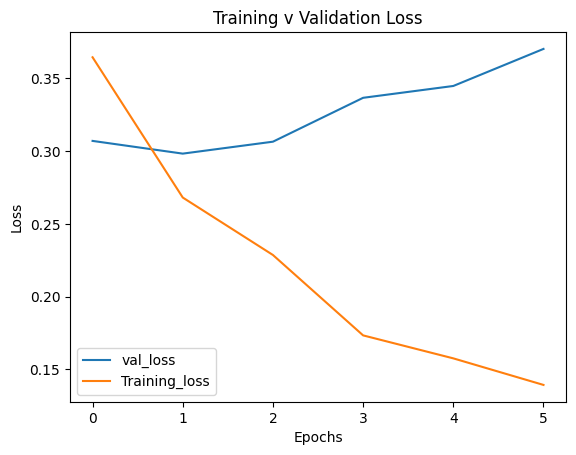

In [42]:
plt.plot(history.history['val_loss'], label= 'val_loss')
plt.plot(history.history['loss'], label = 'Training_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training v Validation Loss')